<a href="https://colab.research.google.com/github/mallaambuluri/my-Machine-Learning-Projects/blob/main/siamese_network_on_mnsit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model


img_A_inp = Input((28, 28), name='img_A_inp')
img_B_inp = Input((28, 28), name='img_B_inp')

def get_cnn_block(depth):
  return Sequential([Conv2D(depth, 3, 1),
                     BatchNormalization(),
                     ReLU()])

DEPTH = 64
cnn = Sequential([Reshape((28, 28, 1)),
                  get_cnn_block(DEPTH),
                  get_cnn_block(DEPTH*2),
                  get_cnn_block(DEPTH*4),
                  get_cnn_block(DEPTH*8),
                  GlobalAveragePooling2D(),
                  Dense(64, activation='relu')])

feature_vector_A = cnn(img_A_inp)
feature_vector_B = cnn(img_B_inp)

concat = Concatenate()([feature_vector_A, feature_vector_B])

dense = Dense(64, activation='relu')(concat)
output = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=[img_A_inp, img_B_inp], outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img_A_inp (InputLayer)      [(None, 28, 28)]             0         []                            
                                                                                                  
 img_B_inp (InputLayer)      [(None, 28, 28)]             0         []                            
                                                                                                  
 sequential_4 (Sequential)   (None, 64)                   1586496   ['img_A_inp[0][0]',           
                                                                     'img_B_inp[0][0]']           
                                                                                                  
 concatenate (Concatenate)   (None, 128)                  0         ['sequential_4[0][0]',    

In [ ]:
import numpy as np

random_indices = np.random.choice(X_train.shape[0], 300, replace=False)

X_train_sample, y_train_sample = X_train[random_indices], y_train[random_indices]

X_train_sample.shape, y_train_sample.shape

((300, 28, 28), (300,))

In [ ]:
len(X_train_sample) ** 2

90000

In [ ]:
import itertools

def make_paired_dataset(X, y):
  X_pairs, y_pairs = [], []

  tuples = [(x1, y1) for x1, y1 in zip(X, y)]

  for t in itertools.product(tuples, tuples):
    pair_A, pair_B = t
    img_A, label_A = t[0]
    img_B, label_B = t[1]

    new_label = int(label_A == label_B)

    X_pairs.append([img_A, img_B])
    y_pairs.append(new_label)

  X_pairs = np.array(X_pairs)
  y_pairs = np.array(y_pairs)

  return X_pairs, y_pairs

In [ ]:
make_paired_dataset(X_train_sample, y_train_sample)

(array([[[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
 
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]],
 
 
        [[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
 
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]],
 
 
        [[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0

In [ ]:
X_train_pairs, y_train_pairs = make_paired_dataset(X_train_sample, y_train_sample)

X_train_pairs.shape, y_train_pairs.shape

((90000, 2, 28, 28), (90000,))

In [ ]:
random_indices = np.random.choice(X_test.shape[0], 150, replace=False)

X_test_sample, y_test_sample = X_test[random_indices], y_test[random_indices]

X_test_sample.shape, y_test_sample.shape

((150, 28, 28), (150,))

In [ ]:
X_test_pairs, y_test_pairs = make_paired_dataset(X_test_sample, y_test_sample)

X_test_pairs.shape, y_test_pairs.shape

((22500, 2, 28, 28), (22500,))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=3)

In [ ]:
model.fit(x=[X_train_pairs[:, 0, :, :], X_train_pairs[:, 1, :, :]],
          y=y_train_pairs,
          validation_data=([X_test_pairs[:, 0, :, :],
                            X_test_pairs[:, 1, :, :]],
                           y_test_pairs),
          epochs=20,
          batch_size=32,
          callbacks=[es])

Epoch 1/20
2813/2813 [==============================] - 132s 47ms/step - loss: 0.1774 - accuracy: 0.9285 - val_loss: 0.1667 - val_accuracy: 0.9370
Epoch 2/20
2813/2813 [==============================] - 132s 47ms/step - loss: 0.0427 - accuracy: 0.9839 - val_loss: 0.1546 - val_accuracy: 0.9587
Epoch 3/20
2813/2813 [==============================] - 130s 46ms/step - loss: 0.0140 - accuracy: 0.9953 - val_loss: 0.2704 - val_accuracy: 0.9424
Epoch 4/20
2813/2813 [==============================] - 131s 46ms/step - loss: 0.0103 - accuracy: 0.9965 - val_loss: 0.2090 - val_accuracy: 0.9547
Epoch 5/20
2813/2813 [==============================] - 131s 47ms/step - loss: 0.0079 - accuracy: 0.9974 - val_loss: 0.1890 - val_accuracy: 0.9580


In [ ]:
img_A, img_B = X_test[0], X_test[17]
label_A, label_B = y_test[0], y_test[17]

label_A, label_B

(7, 7)

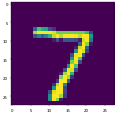

In [ ]:
import matplotlib.pyplot as plt

plt.figure(dpi=28)
plt.imshow(img_A)

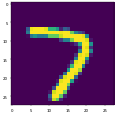

In [ ]:
plt.figure(dpi=28)
plt.imshow(img_B)

In [ ]:
model.predict([img_A.reshape((1, 28, 28)),
               img_B.reshape((1, 28, 28))]).flatten()[0] > 0.5

1/1 [==============================] - 1s 554ms/step


True